Part 4: Homography + RANSAC
Q1. Load im01.jpg and im02.jpg. Based on SIFT, find matches between the two images. Show all the matches
the matches are shown below

In [138]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as  linalg
image_1 = cv2.imread('im01.jpg')
image_2 = cv2.imread('im02.jpg')
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
print(image_1.shape, image_2.shape)
sift = cv2.SIFT_create()
kp_1, dp_1 = sift.detectAndCompute(image_1, None)
kp_2, dp_2 = sift.detectAndCompute(image_2, None)

def key_point_match(kp_1, kp_2, dp_1, dp_2):
    key_point_match_12=[]
    key_point_match_21=[]
    match_pairs=[]
    for i in range(len(kp_1)):
        temp_list=[]
        for j in range(len(kp_2)):
            temp=dp_1[i]-dp_2[j]
            temp=np.sqrt(sum(temp**2))
            temp_list.append((temp,j))
        temp_list.sort(key=lambda x: x[0])
        key_point_match_12.append((int(temp_list[0][0]), temp_list[0][1], i))
    for i in range(len(kp_2)):
        temp_list=[]
        for j in range(len(kp_1)):
            temp=dp_2[i]-dp_1[j]
            temp=np.sqrt(sum(temp**2))
            temp_list.append((temp,j))
        temp_list.sort(key=lambda x: x[0])
        key_point_match_21.append((int(temp_list[0][0]), temp_list[0][1], i))
    for i,(d_12,match_2,k_1) in enumerate(key_point_match_12):
        for j,(d_21,match_1,k_2) in enumerate(key_point_match_21):
            if match_2==k_2 and match_1==k_1:
                match_pairs.append((d_12, match_2, k_1))
    return match_pairs


    

(480, 640, 3) (480, 640, 3)


401


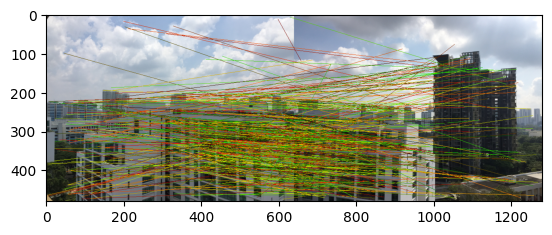

In [104]:
image_show= np.zeros([image_1.shape[0],image_1.shape[1]+image_2.shape[1],3],dtype=np.int32)
image_show[:image_1.shape[0],:image_1.shape[1]]=image_1
image_show[:image_1.shape[0],image_1.shape[1]:]=image_2

matched_points= key_point_match(kp_1,kp_2,dp_1,dp_2)
for matched_point in matched_points:
    (_,k_2,k_1)= matched_point
    color= np.random.randint(0, 255, 3, dtype=np.int32)
    cv2.line(image_show,(int(kp_1[k_1].pt[0]),int(kp_1[k_1].pt[1])),(image_1.shape[1]+(int(kp_2[k_2].pt[0])),int(kp_2[k_2].pt[1])),(int(color[0]),int(color[1]),3),1)
plt.imshow(image_show)
print (len(matched_points))

Q2. Compute the best homography matrix using RANSAC, and show all the inlier matches (matches that support your best homography matrix):

In [163]:
def pick_random(matched_point_set):
    """
    return 4 random coordinates pairs
    """
    p_kp_1=[]
    p_kp_2=[]
    random= np.random.randint(0, len(matched_point_set),4)
    for r in random:
        index_1, index_2= matched_point_set[r][2], matched_point_set[r][1]
        p_kp_1.append((int(kp_1[index_1].pt[0]),int(kp_1[index_1].pt[1])))
        p_kp_2.append((int(kp_2[index_2].pt[0]),int(kp_2[index_2].pt[1])))
    return p_kp_1,p_kp_2


def compute_H(points_1, points_2, show_H):
    d=len(points_1)
    A = np.zeros([2*d, 9])
    for index ,(point_1, point_2) in enumerate(zip (points_1, points_2)):
        (x_1, y_1),(x_2,y_2)= point_1, point_2
        A[2*index, :]=[x_1, y_1,1,0,0,0,-x_2*x_1, -x_2*y_1, -x_2]
        A[2*index+1, :]=[0,0,0,x_1,y_1,1,-y_2*x_1, -y_2*y_1, -y_2]
    U, D, V= linalg.svd(A)
    H= V [-1, :].reshape(3,3)
    H = H / H[2, 2]
    if show_H is True:
        print(H)
    return H

def transform_h_2_h(h_1, h_2,cv_p1,cv_p2,show_H,compute_H,external_H):
    m_list=[]
    n_list=[]
    x,y,z= h_1.shape
    u,v,w= h_2.shape
    if compute_H is not True:
       Matrix_H= external_H
    else :Matrix_H= compute_H(cv_p1, cv_p2, show_H)
    corners= [(0,0),(x-1,0),(x-1,y-1),(0,y-1)]
    for corner in corners:
        m,n= corner
        temp= np.dot(Matrix_H,np.array([m, n, 1]))
        temp_m, temp_n,_ =temp/temp[2]
        m_list.append(int(temp_m))
        n_list.append(int(temp_n))
    max_u,max_v,shift_u,shift_v=int(max(m_list)), int(max(n_list)), int (min(m_list)), int(min(n_list)) 
    print(max_u,max_v,shift_u,shift_v)
    image= np.zeros([max_u-shift_u,max_v-shift_v,3],dtype=np.uint8)
    row=0
    while row<x:
        col=0
        while col < y:
            temp= np.dot(Matrix_H, np.array([row, col, 1]))
            temp_x, temp_y,_= temp/temp[2]
            if shift_u<=temp_x<max_u and shift_v<=temp_y<max_v:
                image[int(temp_x)-shift_u,int(temp_y)-shift_v,:]= h_1[int(row), int(col),:]
            col+=0.2
        row+=0.2
    return image, shift_u,shift_v
   
def Ransac(matched_point_set,image1,image2):
    global threshold, iterations
    image_line=np.zeros([image1.shape[0],image1.shape[1]+image2.shape[1],3],dtype=np.int32)
    image_line[:image1.shape[0],:image1.shape[1]]=image1
    image_line[:image1.shape[0],image1.shape[1]:]=image2
    in_line=-1
    for iteration in range (iterations):
        p_1,p_2= pick_random(matched_point_set)
        Matrix_H= compute_H(p_2, p_1, False)
        candidates=[]
        for match_point in matched_point_set:
            (_, k_2, k_1) = match_point
            x_1,y_1= int(kp_1[k_1].pt[0]), int(kp_1[k_1].pt[1])
            x_2,y_2= int(kp_2[k_2].pt[0]), int(kp_2[k_2].pt[1])
            temp= np.dot(Matrix_H, [x_2,y_2,1])
            x_h, y_h, _ = temp/temp[2]
            diff= (x_h-x_1)**2+(y_h-y_1)**2
            candidates.append((k_2, k_1, np.sqrt(diff)))
        new_candidates= list (filter(lambda x: x[2]<=threshold,candidates))
        if len(new_candidates)>in_line:
           in_line= len(new_candidates)
           inline_match=new_candidates
           inline_H= Matrix_H
        if len(inline_match)>90 :print('iteration:{},length:{}'.format(iteration,len(inline_match)))
        
    for i in inline_match:
        (k_2,k_1,_)=i
        color= np.random.randint(0, 255, 3, dtype=np.int32)
        cv2.line(image_line,(int(kp_1[k_1].pt[0]),int(kp_1[k_1].pt[1])),(image_1.shape[1]+(int(kp_2[k_2].pt[0])),int(kp_2[k_2].pt[1])),(int(color[0]),int(color[1]),3),1)
        

    return image_line, inline_match, inline_H 


iteration:13308,length:91
iteration:13309,length:91
iteration:13310,length:91
iteration:13311,length:91
iteration:13312,length:91
iteration:13313,length:91
iteration:13314,length:91
iteration:13315,length:91
iteration:13316,length:91
iteration:13317,length:91
iteration:13318,length:91
iteration:13319,length:91
iteration:13320,length:91
iteration:13321,length:91
iteration:13322,length:91
iteration:13323,length:91
iteration:13324,length:91
iteration:13325,length:91
iteration:13326,length:91
iteration:13327,length:91
iteration:13328,length:91
iteration:13329,length:91
iteration:13330,length:91
iteration:13331,length:91
iteration:13332,length:91
iteration:13333,length:91
iteration:13334,length:91
iteration:13335,length:91
iteration:13336,length:91
iteration:13337,length:91
iteration:13338,length:91
iteration:13339,length:91
iteration:13340,length:91
iteration:13341,length:91
iteration:13342,length:91
iteration:13343,length:91
iteration:13344,length:91
iteration:13345,length:91
iteration:13

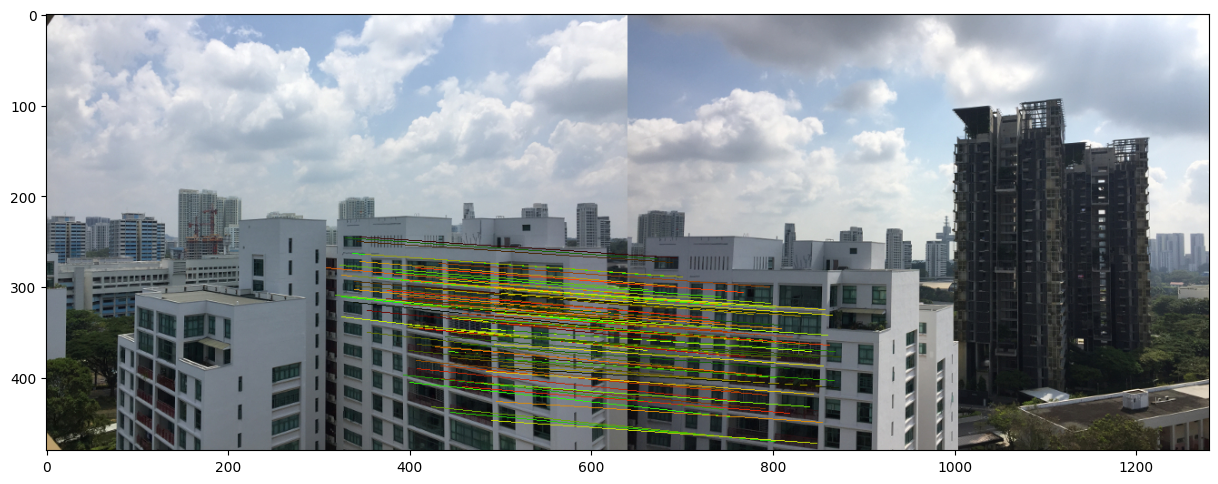

In [165]:
threshold,iterations=1, 15000
image_inline, inline_match, H=Ransac(matched_points,image_1,image_2)
print(H)
plt.figure(figsize=(15,15))
plt.imshow(image_inline)


Q3. Stitch the images together using the best homography matrix and show the result:

867 735 293 -134


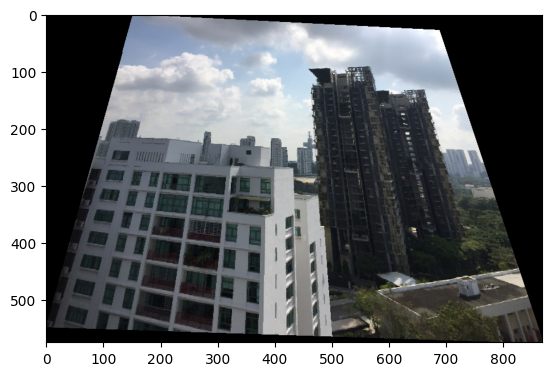

In [168]:
inline_match
image_2_1, shift_h,shift_w=transform_h_2_h(image_2,image_1,None,None,True,False,H)
plt.imshow(image_2_1)


1236.0214 293.78445 594.06177 -241.46681


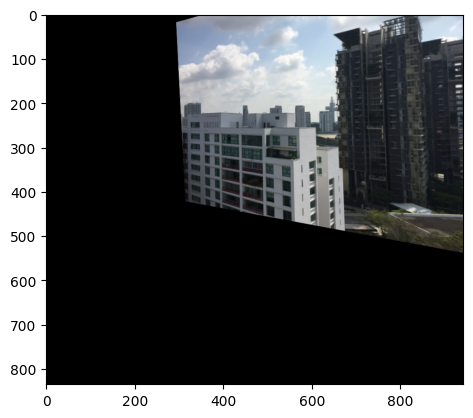

In [169]:
corners_image2 = np.array([[0, 0], [0, image_2.shape[0]], [image_2.shape[1], 0], [image_2.shape[1], image_2.shape[0]]], dtype=np.float32)
transformed_corners = cv2.perspectiveTransform(corners_image2.reshape(-1, 1, 2), H)

# Find the minimum and maximum X and Y coordinates
min_x = np.min(transformed_corners[:, 0, 0])
max_x = np.max(transformed_corners[:, 0, 0])
min_y = np.min(transformed_corners[:, 0, 1])
max_y = np.max(transformed_corners[:, 0, 1])

# Calculate width and height
width = int(max_x - min_x)
height = int(max_y - min_y)
stitched_image = cv2.warpPerspective(image_2, H, (width, height))
plt.imshow(stitched_image)
print(max_x, min_x, max_y, min_y)